In [5]:
import pandas as pd
from datetime import timedelta
import json

def input_timings(num_questions):
    timings = []
    print("Enter the timings (HH:MM:SS) taken for each question starting from the total time (e.g., 01:15:00):")
    for i in range(num_questions):
        time_str = input(f"Time remaining after question {i+1} (HH:MM:SS): ")
        h, m, s = map(int, time_str.split(':'))
        time_remaining = timedelta(hours=h, minutes=m, seconds=s)
        timings.append(time_remaining)
    return timings

def analyze_timings(timings, total_time):
    total_time_delta = timedelta(minutes=total_time)
    data = {
        'Question': list(range(1, len(timings) + 1)),
        'Time Remaining': timings,
        'Time Spent': [total_time_delta - t for t in timings]
    }
    df = pd.DataFrame(data)
    df['Time Spent on Question'] = df['Time Spent'].diff().fillna(df['Time Spent'][0])
    return df

def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"

# Jupyter Notebook specific cells

# Step 1: Enter the name of the paper
paper_name = input("Enter the name of the paper: ")

# Step 2: Enter the number of questions
num_questions = int(input("Enter the number of questions: "))

# Step 3: Input timings for each question
timings = input_timings(num_questions)

# Step 4: Analyze the timings
total_time = 75  # total time for the paper in minutes
analysis_df = analyze_timings(timings, total_time)

# Step 5: Format the timedelta columns for better readability
analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(format_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(format_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(format_timedelta)

# Display the analysis
print("\nTime Analysis:")
print(analysis_df.to_string(index=False))

# Convert the DataFrame to a dictionary
analysis_dict = analysis_df.to_dict(orient='list')
# Add the paper name to the dictionary
analysis_dict['Paper Name'] = paper_name

# Write the dictionary to a JSON file
with open('time_analysis.json', 'w') as json_file:
    json.dump(analysis_dict, json_file, indent=4)

print(f"\nTime analysis has been saved to 'time_analysis.json'")


Enter the timings (HH:MM:SS) taken for each question starting from the total time (e.g., 01:15:00):

Time Analysis:
 Question Time Remaining Time Spent Time Spent on Question
        1       01:07:00   00:08:00               00:08:00
        2       01:05:00   00:10:00               00:02:00
        3       00:59:30   00:15:30               00:05:30
        4       00:56:30   00:18:30               00:03:00
        5       00:51:40   00:23:20               00:04:50
        6       00:46:25   00:28:35               00:05:15
        7       00:40:00   00:35:00               00:06:25
        8       00:36:35   00:38:25               00:03:25
        9       00:32:50   00:42:10               00:03:45
       10       00:31:00   00:44:00               00:01:50
       11       00:27:00   00:48:00               00:04:00
       12       00:24:45   00:50:15               00:02:15
       13       00:21:30   00:53:30               00:03:15
       14       00:17:30   00:57:30               00:04:00

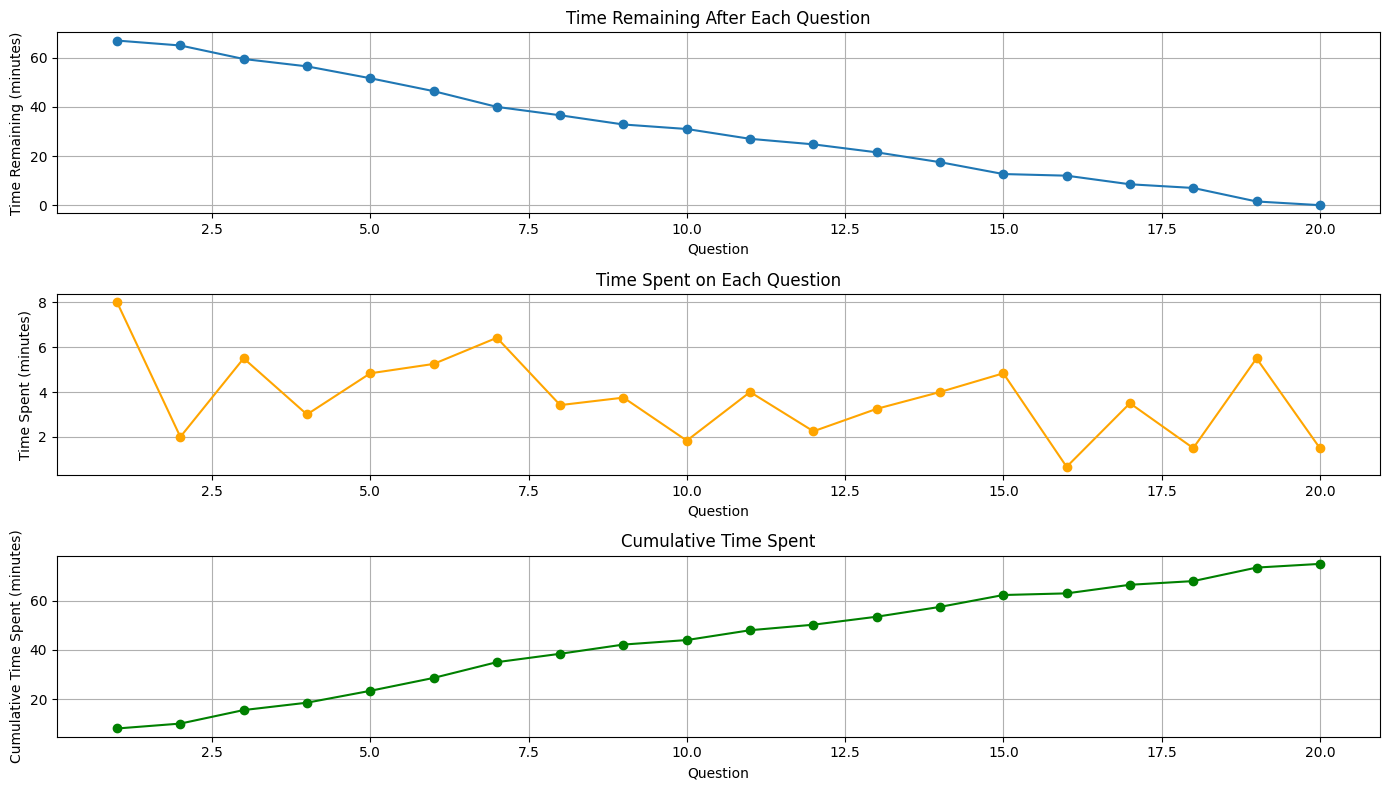

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta

# Load the JSON file
with open('time_analysis.json', 'r') as json_file:
    analysis_dict = json.load(json_file)

# Convert the loaded dictionary back to a DataFrame
analysis_df = pd.DataFrame(analysis_dict)

# Convert time columns from string to timedelta for plotting
def parse_timedelta(time_str):
    h, m, s = map(int, time_str.split(':'))
    return timedelta(hours=h, minutes=m, seconds=s)

analysis_df['Time Remaining'] = analysis_df['Time Remaining'].apply(parse_timedelta)
analysis_df['Time Spent'] = analysis_df['Time Spent'].apply(parse_timedelta)
analysis_df['Time Spent on Question'] = analysis_df['Time Spent on Question'].apply(parse_timedelta)

# Convert timedelta to total minutes for plotting
analysis_df['Time Remaining (m)'] = analysis_df['Time Remaining'].dt.total_seconds() / 60
analysis_df['Time Spent (m)'] = analysis_df['Time Spent'].dt.total_seconds() / 60
analysis_df['Time Spent on Question (m)'] = analysis_df['Time Spent on Question'].dt.total_seconds() / 60

# Plotting
plt.figure(figsize=(14, 8))

# Plot 1: Time Remaining after each question
plt.subplot(3, 1, 1)
plt.plot(analysis_df['Question'], analysis_df['Time Remaining (m)'], marker='o')
plt.title('Time Remaining After Each Question')
plt.xlabel('Question')
plt.ylabel('Time Remaining (minutes)')
plt.grid(True)

# Plot 2: Time Spent on Each Question
plt.subplot(3, 1, 2)
plt.plot(analysis_df['Question'], analysis_df['Time Spent on Question (m)'], marker='o', color='orange')
plt.title('Time Spent on Each Question')
plt.xlabel('Question')
plt.ylabel('Time Spent (minutes)')
plt.grid(True)

# Plot 3: Cumulative Time Spent
plt.subplot(3, 1, 3)
plt.plot(analysis_df['Question'], analysis_df['Time Spent (m)'], marker='o', color='green')
plt.title('Cumulative Time Spent')
plt.xlabel('Question')
plt.ylabel('Cumulative Time Spent (minutes)')
plt.grid(True)

plt.tight_layout()
plt.show()
